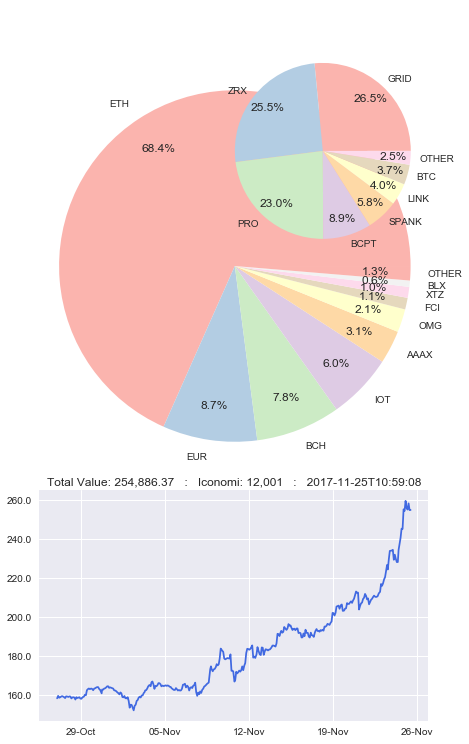

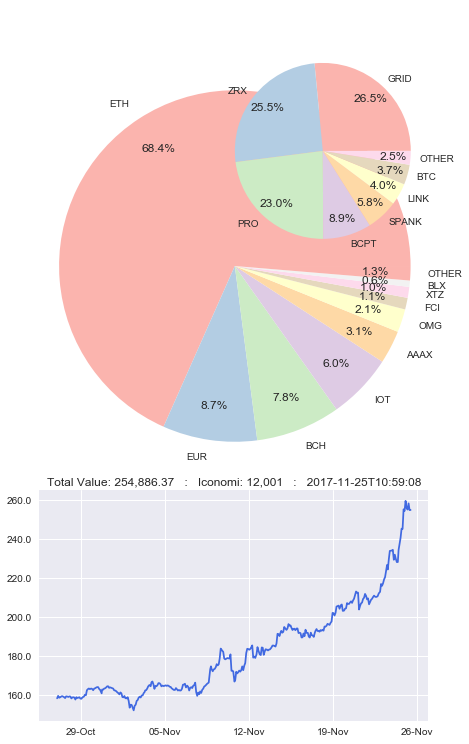

In [2]:
import os, json
import matplotlib.pyplot as plt
#import matplotlib.gridspec as grd
import matplotlib.ticker as tck
import matplotlib.dates as dates
import arrow
import seaborn as sns

arrow_timestamps = []
totals = []
lookback_days = 30
chart_points = 400

# get appropriate number of points for chart for date range

files_to_process = [filename for filename in
                    os.listdir('../data/archive/crypto_values')
                    if filename.endswith("_crypto_values.json")
                    and (arrow.now() - arrow.get(filename[0:10])).days < lookback_days]

files_to_process.sort()
files_to_process = files_to_process[::-max(1, int(round(len(files_to_process) / chart_points, 0)))]
files_to_process.sort()

for filename in files_to_process:
    data = json.loads(open('../data/archive/crypto_values/' + filename).read())
    data_date = arrow.get(data['timestamp'])
    arrow_timestamps.append(data_date)
    totals.append(float(data['data']['total_value'].replace(',', '')))

datetimes = [a.datetime for a in arrow_timestamps]
date_labels = [a.format('MM-DD HH:MM') for a in arrow_timestamps]

# Get PIE Data
crypto_data = json.loads(open('../data/crypto_values.json').read())
crypto_values = crypto_data['data']['values']
timestamp = crypto_data['timestamp'].split('.')[0]
iconomi_value = crypto_data['data']['iconomi_value']

# sort the data by value - there must be a better way!
tuples = crypto_values.items()
sorted_data = sorted(zip([y for _, y in tuples], [x for x, _ in tuples]), reverse=True)

# Data to plot
labels = []
values = []
gravel_value = 0.0
gravel_labels = []
gravel_values = []
dust_value = 0.0

for value, label in sorted_data:

    if value > 1000:
        labels.append(label)
        values.append(int(value))
    elif value > 50:
        gravel_value += value
        gravel_labels.append(label)
        gravel_values.append(int(value))
    else:
        dust_value += value

if gravel_value + dust_value > 1000:
    labels.append('OTHER')
    values.append(int(gravel_value + dust_value))

if dust_value > 5:
    gravel_labels.append('OTHER')
    gravel_values.append(int(dust_value))



sns.set_palette("Pastel1",12)

#with plt.xkcd():
if True: #below to retain indent
    #plt.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(6, 8))
    fig.autofmt_xdate()
    # gs = grd.GridSpec(2, 1, height_ratios=[2, 1])
    # ax1 = plt.subplot(gs[0])
    # ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.44, 0.9, 0.9])  # big pie
    ax2 = fig.add_axes([0.1, 0.1, 0.9, 0.4])
    axMini = fig.add_axes([0.53, 0.89, 0.45, 0.4])

    # ax1.set_title('Total Value: ' + crypto_data['data']['total_value'])  # , bbox={'facecolor': '0.8', 'pad': 3})
    # plt.rcParams.update({'font.size': 14}) #adjust font size; not really needed

    ax1.pie(values,
            labels=labels,
            autopct='%1.1f%%',
            pctdistance=0.8,
            startangle=0)

    ax1.axis('equal')  # ensure pie is round

    axMini.pie(gravel_values,
               labels=gravel_labels,
               autopct='%1.1f%%',
               pctdistance=0.8,
               startangle=0)
    axMini.axis('equal')  # ensure pie is round

    ax2.plot(datetimes, totals, 'royalblue')
    # ax2.set_title('Total Value Over Time (kGBP)')
    ax2.set_title(
        'Total Value: {}   :   Iconomi: {:,.0f}   :   {}'.format(crypto_data['data']['total_value'], iconomi_value,
                                                               timestamp), fontdict={'fontsize':12})
    ax2.get_yaxis().set_major_formatter(tck.FuncFormatter(lambda x, p: format(x / 1000, ',')))

    ax2.xaxis.set_major_formatter(dates.DateFormatter('%d-%b'))

    #plt.savefig('../data/crypto_pie.jpg', bbox_inches='tight')

    #short term hack so i can see it!
    #plt.savefig('../../../../Google Drive/crypto_pie.jpg', bbox_inches='tight')
    plt.show()
